# Homework 8
## Deep Learning Technologies
### Shruti Badrinarayanan - 016768141

[Github Link](https://github.com/shruti-badri-14/Deep-Learning-Homework/tree/main/Assignment%208)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1. Import the data from the given .csv file

In [25]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/Deep Learning/Assignments/Assignment 8/Google_Stock_Price_Train.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


## Step 2. Preprocess the data as you see fit, Step 3. Split into 80% train 20% prediction

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
stock_prices = df['Open'].values.reshape(-1, 1)
scaled_stock_prices = scaler.fit_transform(stock_prices)

# Creating a data structure with 60 time-steps and 1 output
X = []
y = []
for i in range(60, len(scaled_stock_prices)):
    X.append(scaled_stock_prices[i-60:i, 0])
    y.append(scaled_stock_prices[i, 0])
X, y = np.array(X), np.array(y)

# Splitting the dataset into Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshaping the data to fit the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

(X_train.shape, X_test.shape)

((958, 60, 1), (240, 60, 1))

## Step 4. Train the model on the data

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# Converting data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Defining the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the Model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.12013828009366989
Epoch 2, Loss: 0.04509943351149559
Epoch 3, Loss: 0.18416227400302887
Epoch 4, Loss: 0.040215685963630676
Epoch 5, Loss: 0.05100700259208679
Epoch 6, Loss: 0.06433678418397903
Epoch 7, Loss: 0.07046248018741608
Epoch 8, Loss: 0.07114742696285248
Epoch 9, Loss: 0.06852389872074127
Epoch 10, Loss: 0.06403282284736633
Epoch 11, Loss: 0.05855942517518997
Epoch 12, Loss: 0.052687715739011765
Epoch 13, Loss: 0.046939413994550705
Epoch 14, Loss: 0.04202554374933243
Epoch 15, Loss: 0.039179909974336624
Epoch 16, Loss: 0.04021264985203743
Epoch 17, Loss: 0.04412167891860008
Epoch 18, Loss: 0.0436297208070755
Epoch 19, Loss: 0.03862501308321953
Epoch 20, Loss: 0.03398970887064934
Epoch 21, Loss: 0.031214142218232155
Epoch 22, Loss: 0.029333526268601418
Epoch 23, Loss: 0.026858288794755936
Epoch 24, Loss: 0.021723324432969093
Epoch 25, Loss: 0.011943647637963295
Epoch 26, Loss: 0.1519974023103714
Epoch 27, Loss: 0.019205639138817787
Epoch 28, Loss: 0.03976732864

## Step 5. Report on the results of your model

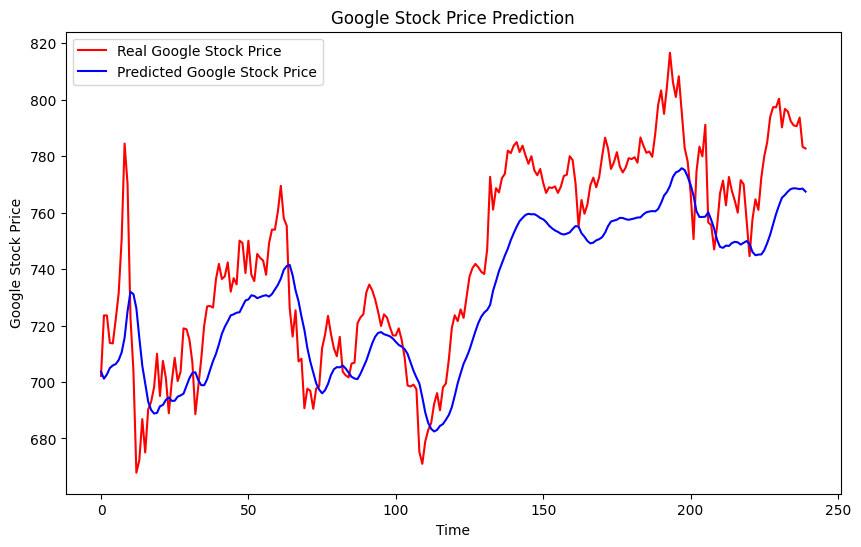

In [23]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Inference mode, gradients not needed
    predicted_stock_price = model(X_test_torch)
    predicted_stock_price = predicted_stock_price.cpu().numpy()

# Inverse transform to get back to original price scale
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Inverse transform to get original price values for the test set
real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualizing the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate MSE
mse = mean_squared_error(real_stock_price, predicted_stock_price)

# Calculate MAE
mae = mean_absolute_error(real_stock_price, predicted_stock_price)

# Calculate R2 Score
r2 = r2_score(real_stock_price, predicted_stock_price)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')

Mean Squared Error (MSE): 456.40609684780975
Mean Absolute Error (MAE): 18.394514068603517
R² Score: 0.6267754806459406


# Key observations from the results:

* The model seems to perform well in terms of following the overall trend.
There might be overfitting or underfitting in certain segments, suggested by the places where the predicted line diverges from the actual prices.
* The model might be more sensitive to sudden changes or less common patterns, which is typical in time-series forecasting.
* Mean Squared Error (MSE) of 456.41: This value indicates that, on average, the squares of the errors between the predicted and actual stock prices are 456.41. Since MSE is sensitive to outliers and errors are squared before they are averaged, this high value suggests there might be some predictions that are significantly different from the actual prices.
* Mean Absolute Error (MAE) of 18.39: This metric tells us that, on average, the predictions are about $18.39 away from the actual price. The MAE is less sensitive to outliers than MSE and gives a more straightforward interpretation of the prediction errors.
* R² Score of 0.627: Suggests that around 63% of the variability in the real stock prices is explained by the model's predictions. This is a decent score, especially considering the complexity and volatility of stock price movements.
* Overall, the results seem promising, but they could potentially be improved with more data, feature engineering (like incorporating volume or other indicators), hyperparameter tuning, and using techniques to prevent overfitting, such as regularization or dropout layers.